In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import h5py
import random
from sklearn import preprocessing
import seaborn as sns; sns.set_theme()
import linear_optimizer5
#import scipy
#import tensorflow_addons as tfa

1.4.1
1.7.1


In [2]:
from numpy import random
import math
import matplotlib.pyplot as plt
import matplotlib

In [3]:
#calculate link table , xij = 1 if node i has direct link with node j

def calculate_link_table(position,signal_range,number_of_nodes):

    link_table = np.zeros((number_of_nodes,number_of_nodes))
    
    #print(link_table.shape)

    for a in range(number_of_nodes):
    
        p1 = [position[a][0],position[a][1]]
    
        for b in range(number_of_nodes):
        
            p2 = [position[b][0],position[b][1]]
        
            distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
        
            if distance<=signal_range:
            
                link_table[a,b] = 1
            
    return(link_table)

In [4]:
def draw_network(position,\
                 link_table,\
                 link_flow_information=[],\
                 cancave_size=[4000,4000],\
                 number_of_nodes = 25,\
                 heat_map_ground_truth = np.zeros((32,32)),\
                 label_number = 5):
    
    base_line_traffic = 500
    
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    

    
    #---------- plot background traffics ------------
    
    #optional_background_color = ['darkred','orangered','orange','navajowhite','white']
    
    optional_background_color = ['whitesmoke','navajowhite','orange','orangered','darkred']
    
    total_color_number = len(optional_background_color)
    
    x_ratio = float(cancave_size[0]/heat_map_ground_truth.shape[0])
    
    y_ratio = float(cancave_size[1]/heat_map_ground_truth.shape[1])
    
    width = x_ratio
    
    height = y_ratio
    
    #print('check width height ',width, height)
    
    for row_number in range(heat_map_ground_truth.shape[0]):
        
        for col_number in range(heat_map_ground_truth.shape[1]):
            
            back_ground_vlaue = heat_map_ground_truth[row_number][col_number]
            
            convert_to_color_index = back_ground_vlaue/(label_number-1)*(total_color_number-1)
            
            #print(back_ground_vlaue,convert_to_color_index)
            
            use_color = optional_background_color[int(convert_to_color_index)]
            
            x_corner = row_number*x_ratio
            
            y_corner = col_number*y_ratio
            
            rect = matplotlib.patches.Rectangle((x_corner,y_corner), width ,height, facecolor=use_color)
            
            ax.add_patch(rect)
            
            #print(x_corner,y_corner,use_color)

            #PIL.ImageDraw.Draw.rectangle([(x_corner),(y_corner),(x_corner+width),(y_corner+height)], fill=use_color, outline=None)
            
            
    #fig.savefig('test.png', dpi=90, bbox_inches='tight')
            
    plt.xlim(0, cancave_size[0])
    plt.ylim(0, cancave_size[1]) 
    
    #plt.show()
    
    #---------- plot nodes and traffics-------------
    
    text =[]
    for a in range(number_of_nodes):
        text.append(str(a))
    
    #print(text)

    for a in range(number_of_nodes):
    
        plt.annotate(text[a],(position[a][0]+20, position[a][1]+20))
        plt.scatter(position[a][0], position[a][1])

    for a in range(number_of_nodes):
    
        point1=[position[a][0],position[a][1]]
        
        for b in range(number_of_nodes):
        
            point2=[position[b][0],position[b][1]]
        
            if link_table[a][b] == 1:
            
                x_values = [point1[0], point2[0]]
            
                y_values = [point1[1], point2[1]]
            
                plt.plot(x_values, y_values, linestyle='dashed')
                
    if len(link_flow_information)>0:
        
        total_number_of_flows = link_flow_information[-1][0]
        
        color_options = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
        
        total_color_options = len(color_options)
        
        for a in link_flow_information:
            
            flow_number = a[0]
                
            start_node = int(a[1])
                
            end_node = int(a[2])
                
            traffic_on_link = a[3]
                
            point1=[position[start_node][0],position[start_node][1]]
                
            point2=[position[end_node][0],position[end_node][1]]
                
            x_values = [point1[0], point2[0]]
            
            y_values = [point1[1], point2[1]]
            
            plt.plot(x_values, \
                     y_values,\
                     color = color_options[int(flow_number%total_color_options)], \
                     linewidth=traffic_on_link/base_line_traffic)
                
    plt.show()        
            
            
        
        

In [5]:
def renew_table(routing_table,number_of_nodes):
    
    temp_table = np.zeros((number_of_nodes,number_of_nodes))
    
    #temp_table = routing_table
    
    #output_table = routing_table
    
    output_table = np.zeros((number_of_nodes,number_of_nodes))
    
    for a in range(number_of_nodes):
    
        for b in range(number_of_nodes):
            
            temp_table[a][b] = routing_table[a][b]
            
            output_table[a][b] = routing_table[a][b]

    for a in range(number_of_nodes):
    
        for b in range(number_of_nodes):
            
            gate_way = temp_table[a][b]
        
            if not np.isnan(gate_way):
            
                #print('check 1 - ',a,b,temp_table[a][b])
            
                #check table for node b
                for c in range(number_of_nodes):
                
                    if not np.isnan(temp_table[b][c]):
                    
                        if np.isnan(temp_table[a][c]):
                        
                            output_table[a][c] = gate_way #b
                            
                            #print('renew table position ',a,c, 'with value', b)
                        
    return (output_table)

In [6]:
def find_routing_table(link_table,max_hop_number,number_of_nodes):
    
    #build routing table, xij = k reprsensts from node i to j, the gateway is k
    routing_table = np.zeros((number_of_nodes,number_of_nodes))

    # step 1: add 1-hop neighbour
    for a in range(number_of_nodes):
    
        for b in range(number_of_nodes):
        
            if link_table[a][b]==1:
            
                routing_table[a][b] = b
            
            else:
            
                routing_table[a][b] = np.nan
            
    #print(routing_table)
    
    # step 2 keep tracing
    for a in range(max_hop_number-1):
        routing_table = renew_table(routing_table,number_of_nodes)
    
    #print('----------------------------')
    #print(routing_table)
    
    return routing_table

In [7]:
#input routing table and comminication pair information, calculate which nodes have traffics flow through

#output:[[traffic flow 0 intemidiate nodes],[traffic flow 1 intemidiate nodes],...]

def find_intermidiate_nodes_for_each_flow(routing_table,communication_pairs,max_hop_number):

    total_number_of_flows =len(communication_pairs) 

    occupied_links =[]

    max_try = max_hop_number + 3 #should be +1, give up if too many tries

    for a in range(total_number_of_flows):

        start_node = int(communication_pairs[a][0])
    
        end_node = int(communication_pairs[a][1])
    
        #find the gate_way in routing table
        intermidiate_nodes = [start_node]
    
        if not np.isnan(routing_table[start_node][end_node]):
    
            add_inter_node = int(routing_table[start_node][end_node])
    
            intermidiate_nodes.append(add_inter_node)
        
            count = 0
    
            while (add_inter_node != end_node) and (count<max_try):
        
                add_inter_node = int(routing_table[add_inter_node][end_node])
        
                intermidiate_nodes.append(add_inter_node)
            
                count+=1
            
            if count != max_try:
        
                occupied_links.append(intermidiate_nodes)
        
            #print(intermidiate_nodes)
            
    return occupied_links

In [8]:
# input (1)which nodes have traffcis flow through, (2) traffic rate for each flow
#find which links has traffics flow through, and expected traffic rate flow through the link 
#output format: flow number \ start node \ end node \ expected traffics on link
def find_which_link_has_traffics(occupied_links,traffic_flow,communication_pairs):
    
    
    list_all_link_pairs=[]
    '''
    count = 0

    for a in occupied_links:

    
        count2 = 0
    
        for c in communication_pairs:
        
            if a[0]==c[0] and a[-1]==c[1]:
    
                traffic = traffic_flow[count2]
        
            count2 += 1
        
        traffic = 
    
        for b in range(len(a)-1):
        
            add_pair = [count,a[b],a[b+1],traffic]
        
            list_all_link_pairs.append(add_pair)
        
        
        count +=1   
    '''
    
    for flow_number in range(len(occupied_links)):
        
        intermidiate_nodes_for_flow = occupied_links[flow_number]
        
        for links_number in range(len(intermidiate_nodes_for_flow)-1):
        
            flow_start = occupied_links[flow_number][links_number]
        
            flow_end   = occupied_links[flow_number][links_number+1]
        
            traffic    = traffic_flow[flow_number]
        
            list_all_link_pairs.append([flow_number,flow_start,flow_end,traffic])  
    
    return(list_all_link_pairs)

In [9]:
#find angles for two vectors v1 and v2
def angle(v1, v2):
    dx1 = v1[2] - v1[0]
    dy1 = v1[3] - v1[1]
    dx2 = v2[2] - v2[0]
    dy2 = v2[3] - v2[1]
    angle1 = math.atan2(dy1, dx1)
    angle1 = int(angle1 * 180/math.pi)
    # print(angle1)
    angle2 = math.atan2(dy2, dx2)
    angle2 = int(angle2 * 180/math.pi)
    # print(angle2)
    if angle1*angle2 >= 0:
        included_angle = abs(angle1-angle2)
    else:
        included_angle = abs(angle1) + abs(angle2)
        if included_angle > 180:
            included_angle = 360 - included_angle
    return included_angle

In [10]:
# anlysis data link, find how the antennas affect the channels 
#output directional antenna effect maps
def find_directional_antenna_effect_map_v2(list_all_link_pairs,occupied_links,channel_effects_map_size,cancave_size,signal_range,antenna_angle,position):

    if len(occupied_links)==0:
        
        return(np.zeros((0,0,channel_effects_map_size[0],channel_effects_map_size[1])))
    
    max_length = len(occupied_links[0])-1
    
    for a in occupied_links:
        
        max_length = max(max_length,len(a)-1)

    effect_map = np.zeros((len(occupied_links),max_length,channel_effects_map_size[0],channel_effects_map_size[1]))

    virtual_to_real_distance_ratio = cancave_size[0]/channel_effects_map_size[0]

    #print(virtual_to_real_distance_ratio)
    
    link_number = -1
    
    preivous_flow_number = 0

    for a in list_all_link_pairs:
    
        flow_number = a[0]
    
        start_node = a[1]
    
        end_node =a[2]
    
        traffic_rate = a[3]
        
        
    
        if flow_number == preivous_flow_number:
            
            link_number+=1
            
        else:
            
            preivous_flow_number = flow_number
            
            link_number = 0
        
        
        
    
        start_node_position = [position[start_node][0],position[start_node][1]]
    
        end_node_position = [position[end_node][0],position[end_node][1]]
    
        for b in range(channel_effects_map_size[0]):
        
            for c in range(channel_effects_map_size[1]):
            
                consider_location = [(b+0.5)*virtual_to_real_distance_ratio,(c+0.5)*virtual_to_real_distance_ratio]
            
                vector = [consider_location[0] - start_node_position[0],consider_location[1] - start_node_position[1]]
            
                r = math.sqrt(vector[0]**2 + vector[1]**2)
            
                if r<=signal_range:
                
                    v1=[start_node_position[0],start_node_position[1],end_node_position[0],end_node_position[1]]
                
                    v2=[start_node_position[0],start_node_position[1],consider_location[0],consider_location[1]]
                
                    check_angle = angle(v1, v2)
            
                    if check_angle<= antenna_angle/2:
            
                        effect_map[flow_number][link_number][b][c] = traffic_rate
                
                #make sure that start node location is considered
                
                x_val = min(start_node_position[0]/virtual_to_real_distance_ratio,channel_effects_map_size[0]-1)
                
                y_val = min(start_node_position[1]/virtual_to_real_distance_ratio,channel_effects_map_size[1]-1)
                
                effect_map[flow_number][link_number][int(x_val)][int(y_val)] = traffic_rate
    
    #print(effect_map.shape)  
    
    return effect_map

'''
a = find_directional_antenna_effect_map_v2(list_all_link_pairs=[],\
                                           occupied_links=[],\
                                           channel_effects_map_size=[256,256],\
                                           cancave_size=[3000,3000],signal_range=5000,\
                                           antenna_angle=60,position=[[1,1],[2,2]])

print(a.shape)
'''


'\na = find_directional_antenna_effect_map_v2(list_all_link_pairs=[],                                           occupied_links=[],                                           channel_effects_map_size=[256,256],                                           cancave_size=[3000,3000],signal_range=5000,                                           antenna_angle=60,position=[[1,1],[2,2]])\n\nprint(a.shape)\n'

In [11]:
#input which traffics has conflicts with each other and expected link traffic
#output traffic flow rate under traffic control
#output format: flow number \ start node \ end node \ date rate on link with traffic control

def find_data_rate_for_links_under_traffic_control_v2(list_all_link_pairs,\
                                                      effect_map_v2,\
                                                      max_single_flow_data_rate,\
                                                      number_of_nodes,\
                                                      position,\
                                                      cancave_size,\
                                                      occupied_links,\
                                                      wirless_channel_map):
    
    if len(list_all_link_pairs) == 0:
        
        return [np.zeros((number_of_nodes,0)),\
                np.zeros((number_of_nodes,0)),\
                [],\
                np.zeros((0,4))]
    
    #print('effect_map_v2 shape ',effect_map_v2.shape)
    
    fix_traffics_on_each_link =np.zeros((len(list_all_link_pairs),4))
    
    number_fow_flows = list_all_link_pairs[-1][0]+1
    
    # antenna effect map length and width
    antenna_map_x = effect_map_v2.shape[2]
    antenna_map_y = effect_map_v2.shape[3]
    
    #real and map ratio
    x_ratio = float(cancave_size[0]/antenna_map_x)
    
    y_ratio = float(cancave_size[1]/antenna_map_y)
    
    #for each single node, find which traffic flows it engage into
    #table format: node 1: flow 1 occupied capcitance \ flow 2 occupied capcitance\.....
    node_effect_table = np.zeros((number_of_nodes,number_fow_flows))
    
    for node_name in range(number_of_nodes):
        
        node_position_x = position[node_name][0]
        
        node_position_y = position[node_name][1]
        
        x_map = min(node_position_x/x_ratio,antenna_map_x-1)
        
        y_map = min(node_position_y/y_ratio,antenna_map_y-1)
        
        #print('node ',node_name,' position ',int(x_map),int(y_map))
        
        for flow_number in range(effect_map_v2.shape[0]):
            
            for link_number in range(effect_map_v2.shape[1]):
                
                #print('flow_number;link_number;effect_map vale -- ',flow_number,link_number,effect_map_v2[flow_number][link_number][int(x_map)][int(y_map)])
                
                # if it's the start or end node of a traffic flow, only half of wireless capacitance will be occupied
                
                if (link_number == 0) or (link_number == effect_map_v2.shape[1]-1):
                    
                    occupied_capacity_by_that_link = effect_map_v2[flow_number][link_number][int(x_map)][int(y_map)]
                    #print('C1 pass - start/end end')
                    
                elif (not effect_map_v2[flow_number,link_number+1,:,:].any()):
                    
                    occupied_capacity_by_that_link = effect_map_v2[flow_number][link_number][int(x_map)][int(y_map)]
                    #print('C2 pass - end end')
                    
                # if that's the intermidiate node, half time need to used to accept, half time is used as sending
                    
                else:
            
                    occupied_capacity_by_that_link = 2*effect_map_v2[flow_number][link_number][int(x_map)][int(y_map)]
                    #print('C3 pass - intermidate node')
                               
                
                node_effect_table[node_name][flow_number] += occupied_capacity_by_that_link
                
             
    '''
    print('---------node_effect_table---------')
    for a in node_effect_table:        
        print(a)
    '''
    
    
    
    
    
    [jame_node_list,fix_node_effect_table] = distribute_wireless_channels\
    (node_effect_table,2*max_single_flow_data_rate,wirless_channel_map,position,cancave_size)
     
    
    '''
    print('jame_node_list ',jame_node_list)
    print('---------fix_node_effect_table---------')
    for a in fix_node_effect_table:        
        print(a)   
    '''
    
        
    # for each node, calculate max data rate it can controbute to each flow
    count_flow_index = 0
    
    for a in occupied_links:
        
        intermidate_nodes_number = len(a)-2
        
        if intermidate_nodes_number>0:
            
            for count0 in range(1,len(a)-1):
                
                intermidate_nodes_name = a[count0]
                
                fix_node_effect_table[intermidate_nodes_name][count_flow_index] = \
                fix_node_effect_table[intermidate_nodes_name][count_flow_index]/2
                
        count_flow_index +=1
        

    '''          
    print('---------find max data rate for each node in fix_node_effect_table ---------')
    for a in fix_node_effect_table:        
        print(a)   
    '''
    

    # finally, work on fix_traffics_on_each_link; list traffic on each link
    # with traffic control, the max data rate can be reached by a flow is limited by bottleneck nodes
    
    max_flow_rate = np.ones(number_fow_flows)* max_single_flow_data_rate
    
    for a in fix_node_effect_table:
        
        for b in range(number_fow_flows):
            
            if a[b]!=0:
            
                max_flow_rate[b] = min(a[b],max_flow_rate[b])
            
            
    #print('max_flow_rate ',max_flow_rate)
        
    for row in range(fix_traffics_on_each_link.shape[0]):
        
        flow_number = list_all_link_pairs[row][0]
        
        link_start  = list_all_link_pairs[row][1]
        
        link_end    = list_all_link_pairs[row][2]
        
        traffic_on_flow = max_flow_rate[flow_number]
        
        fix_traffics_on_each_link[row][0] = flow_number
        
        fix_traffics_on_each_link[row][1] = link_start
        
        fix_traffics_on_each_link[row][2] = link_end
        
        fix_traffics_on_each_link[row][3] = traffic_on_flow
            
    return [node_effect_table,fix_node_effect_table,jame_node_list,fix_traffics_on_each_link]


In [12]:
def distribute_wireless_channels(node_effect_table,one_hop_max_wireless_channel_capacity,wirless_channel_map,position,cancave_size):
    
    fair_distirbute_flow_for_each_node = np.zeros((node_effect_table.shape[0],node_effect_table.shape[1]))
    
    jame_node_list = []
    
    x_ratio = float(cancave_size[0]/wirless_channel_map.shape[0])
    
    y_ratio = float(cancave_size[1]/wirless_channel_map.shape[1])
    
    for count0 in range(node_effect_table.shape[0]):
        
        traffics_on_node = node_effect_table[count0]
        
        #----------------utlize wireless channel map to find out aviable wireless channel capacitance for this node-------------
        
        node_position_x = min(int(position[count0][0]/x_ratio),wirless_channel_map.shape[0]-1)
        
        node_position_y = min(int(position[count0][1]/y_ratio),wirless_channel_map.shape[1]-1)
        
        aviable_channel_capacitance = wirless_channel_map[node_position_x][node_position_y]
        
        #print('--------aviable_channel_capacitance---------')
        #print(aviable_channel_capacitance)
        
        #------------------------------
        
        #aviable_channel_capacitance = one_hop_max_wireless_channel_capacity
        #print('check node : ',count0)
        
        [is_jame_node,fix_node_traffics] = distribut_channel_capacity(traffics_on_node,aviable_channel_capacitance)
        
        
        #print('check fix_node_traffics',fix_node_traffics)
        
        if is_jame_node:
            
            jame_node_list.append(count0)
        
        for count1 in range(len(fix_node_traffics)):
            
            #print('[count0][count1]',count0,count1)
            
            fair_distirbute_flow_for_each_node[count0][count1] = fix_node_traffics[count1]
            
            
    return [jame_node_list,fair_distirbute_flow_for_each_node]
            
            
    

In [13]:
def distribut_channel_capacity(traffics_on_node,one_hop_max_wireless_channel_capacity):
    
    sum_of_all_traffic = 0
    
    is_jame_node = 0
    
    for a in traffics_on_node:
        
        sum_of_all_traffic+=a
        
    #print('sum_of_all_traffic ',sum_of_all_traffic)
        
    # if the wireless channel havn't be fully utlized, no need to sacrisfis any traffics
        
    if sum_of_all_traffic<=one_hop_max_wireless_channel_capacity:
        
        return [is_jame_node,traffics_on_node]
    
    is_jame_node = 1
    
    
    # else, distribute wireless channel evenly
    number_of_flows = len(traffics_on_node)
    
    avilable_data_rate = one_hop_max_wireless_channel_capacity/number_of_flows
    
    lefted_data_rate = one_hop_max_wireless_channel_capacity
    
    #print('avilable_data_rate ',avilable_data_rate,' ; lefted_data_rate ',lefted_data_rate)
    
    output = np.zeros(number_of_flows)
    
    count = 0
    
    for a in range(number_of_flows):
        
        if traffics_on_node[a]<=avilable_data_rate:
            
            output[a] = traffics_on_node[a]
            
            lefted_data_rate-=traffics_on_node[a]
            
            count+=1
            
    average_the_left_rate = float(lefted_data_rate/(number_of_flows-count))
    
    for a in range(number_of_flows):
        
        if traffics_on_node[a]>avilable_data_rate:
            
            output[a] = average_the_left_rate
            
    return [is_jame_node,output]
            
            
#print(distribut_channel_capacity(traffics_on_node =[0,2000,2000],one_hop_max_wireless_channel_capacity =5000))    
    
    

In [14]:
def find_data_rate_for_links_without_traffic_control_v2(node_effect_table,\
                                                        fix_node_effect_table,\
                                                        jame_node_list,\
                                                        fix_traffics_on_each_link_with_traffic_control,\
                                                        occupied_links,\
                                                        traffic_flow,\
                                                        flow_start_index,\
                                                        flow_end_index):
    

    #print('traffic_flow ,',traffic_flow)

    
    traffics_without_traffic_control = np.zeros((fix_traffics_on_each_link_with_traffic_control.shape[0],\
                                                 fix_traffics_on_each_link_with_traffic_control.shape[1]))
    
    if len(occupied_links) == 0:
        
        return traffics_without_traffic_control
    
    for count in range(len(flow_start_index)):
        
        start_index = flow_start_index[count]
        
        end_index   = flow_end_index[count]
        
        current_flow_rate = traffic_flow[count]
        
        #print('++++++++++++++++++++++++++++++++++++++++++++++++++')
        #print('check current_flow_rate assignment ',current_flow_rate)
        
        
        #print('current_flow_rate ',current_flow_rate,' ; traffic_flow[count] ',traffic_flow[count],' ; [count] ',count)
        
        for row_index in range(int(start_index),int(end_index+1)):
            
            flow_number = fix_traffics_on_each_link_with_traffic_control[row_index][0]
            
            start_node  = fix_traffics_on_each_link_with_traffic_control[row_index][1]
            
            end_node    = fix_traffics_on_each_link_with_traffic_control[row_index][2]
            
            if start_node in jame_node_list:
                
                '''
                print('start_node ',start_node)
                print('traffic_flow ',traffic_flow,' ; [count] ',count,' ; has value ',traffic_flow[count])
                print('check again current_flow_rate ',current_flow_rate)
                print('fix_node_effect_table value ',fix_node_effect_table[int(start_node)][int(flow_number)])
                '''
                
                current_flow_rate = min(current_flow_rate,fix_node_effect_table[int(start_node)][int(flow_number)])
                
            
            traffics_without_traffic_control[row_index][0] = flow_number
            
            traffics_without_traffic_control[row_index][1] = start_node
            
            traffics_without_traffic_control[row_index][2] = end_node
            
            traffics_without_traffic_control[row_index][3] = current_flow_rate
            
            
    # the node previous to jame node should notice that the wireless channel is funnly occupied, no packets should be send out
    
    traffics_without_traffic_control = \
    fix_jame_node_previous_intermidate_node_sending_rate(traffics_without_traffic_control,flow_start_index)
            
    #double check to make sure the reciver's receing rate is OK
    
    for end_index in flow_end_index:
        
        traffics_without_traffic_control[int(end_index)][-1] = fix_traffics_on_each_link_with_traffic_control[int(end_index)][-1]
            
            
    return traffics_without_traffic_control

In [15]:
def fix_jame_node_previous_intermidate_node_sending_rate(traffics_without_traffic_control,flow_start_index):
    
    output = traffics_without_traffic_control.copy()
    
    for count in range(0,len(output)-1):
        
        if (count+1) not in flow_start_index:
        
            current_traffic = output[count][-1]
        
            next_node_traffic = output[count+1][-1]
        
            if current_traffic>next_node_traffic:
            
                output[count][-1] = next_node_traffic
                
    return output
        
    

In [16]:

#------------------- functions below define channel properties ------------------------------------------------


In [17]:
#free space model to calculate signal strength
def calculate_FSPL(distance_between_nodes,signal_frequency): #input distance/frequency unit: Hz/meter
    
    f = signal_frequency/math.pow(10,9) #unit GHz
    
    d = distance_between_nodes #unit: meter
    
    if d==0:
        
        FSPL = 0
        
    else:
    
        FSPL = 20*math.log(d,10) + 20*math.log(f,10) + 92.45
    
    return FSPL

In [18]:
def find_packets_acception_rate_by_rxPower(rxPower,noise,shift_right_PCR_curve = 0):

    signal_noise_ratio = rxPower - noise #dB
    
    #signal_noise_ratio = 10**(signal_noise_ratio/10)
    
    packets_acception_rate = 0
    
    turn_value0 = -1 + shift_right_PCR_curve
    turn_value1 = 0  + shift_right_PCR_curve
    turn_value2 = 1  + shift_right_PCR_curve
    turn_value3 = 2  + shift_right_PCR_curve
    turn_value4 = 3  + shift_right_PCR_curve
    turn_value5 = 4  + shift_right_PCR_curve
    turn_value6 = 5  + shift_right_PCR_curve
    turn_value7 = 6  + shift_right_PCR_curve
    
    ratio0_1 = 0.3
    ratio1_2 = 10.2
    ratio2_3 = 39.8
    ratio3_4 = 34.6
    ratio4_5 = 12.6
    ratio5_6 = 2.2
    ratio6_7 = 0.3
    
    if signal_noise_ratio>= (turn_value7):
        
        packets_acception_rate = 100
    
    elif signal_noise_ratio>= (turn_value6):
        
        packets_acception_rate = 99.7 + ratio6_7*(signal_noise_ratio-turn_value6)
        
    elif signal_noise_ratio>= (turn_value5):  
        
        packets_acception_rate = 97.5 + ratio5_6*(signal_noise_ratio-turn_value5)

    elif signal_noise_ratio>= (turn_value4):  
        
        packets_acception_rate = 84.9 + ratio4_5*(signal_noise_ratio-turn_value4)
        
    elif signal_noise_ratio>= (turn_value3):  
        
        packets_acception_rate = 50.3 + ratio3_4*(signal_noise_ratio-turn_value3)
        
    elif signal_noise_ratio>= (turn_value2):  
        
        packets_acception_rate = 10.5 + ratio2_3*(signal_noise_ratio-turn_value2)
        
    elif signal_noise_ratio>= (turn_value1):  
        
        packets_acception_rate = 0.3 + ratio1_2*(signal_noise_ratio-turn_value1)
        
    else:
        
        packets_acception_rate = 0
        
    return packets_acception_rate

In [19]:
def find_packets_acception_rate(distance_between_nodes = 1000,signal_frequency = 122.75*math.pow(10,6),enable_to_add_random_loss_base = 1,wireless_channel_random_loss_base = 0.01,txPower = 0,txAntennaGain = 0,rxAntennaGain = 0, noise = -136.5):
    
    #the last parameter enable_to_add_random_loss_base will add randome loss which has normal distribution

    pathloss = calculate_FSPL(distance_between_nodes,signal_frequency)

    rxPower = txPower + txAntennaGain + rxAntennaGain-pathloss

    acception_rate = find_packets_acception_rate_by_rxPower(rxPower,noise = noise,shift_right_PCR_curve = 0)/100
    
    if enable_to_add_random_loss_base == 1:
        
        add_loss = abs(random.normal(loc=wireless_channel_random_loss_base, scale=wireless_channel_random_loss_base/4,size=1))
        
        acception_rate -= add_loss
        
        if  acception_rate <=0:
            
            acception_rate = 0

    return acception_rate

In [20]:

#------------------- functions below are used to calculate delay and throughput foe each traffic flows-----------


In [21]:
def find_index_for_each_flow_in_list(fix_traffics_on_each_link):
    
    flow_start_index = np.zeros(0)
    
    if len(fix_traffics_on_each_link)>0:
    
        aviable_flows = int(fix_traffics_on_each_link[-1][0])+1

        temp_list = np.zeros(aviable_flows)

        count = 0

        for a in fix_traffics_on_each_link:
    
            deal_with_flow = int(a[0])
    
            temp_list[deal_with_flow] += 1
    
        #print(temp_list)
    
        flow_start_index = np.zeros(len(temp_list))

        count = 0

        if len(temp_list)>0:

            flow_start_index[0] =  temp_list[0]

        for a in range(1,aviable_flows):
    
            #print(a)
    
            flow_start_index[a] = temp_list[a] + flow_start_index[a-1]
        
        #print(flow_start_index)
        
        # what we have is a index which indicate the end of each flow, we want to have index which indicate start of a flow
        flow_start_index = np.insert(flow_start_index,0,0,axis = 0)
        
        flow_start_index = np.delete(flow_start_index,-1)
        
        #print(flow_start_index)
        
        
        
    flow_end_index = []
    
    for a in range(1,len(flow_start_index)):
        
        flow_end_index.append(flow_start_index[a]-1)
        
    flow_end_index.append(len(fix_traffics_on_each_link)-1)
    
    
                 
    return ([flow_start_index,flow_end_index])  

In [22]:
# find packets send delivery rate base on hop number
# return table format:
# flow number \ sender \ receiver \ data rate send out rate \ data receive rate

def find_send_and_receive_data_rate(fix_traffics_on_each_link_with_traffic_control,\
                                    fix_traffics_on_each_link,\
                                    position,\
                                    flow_start_index,\
                                    signal_frequency,\
                                    wireless_channel_random_loss_base,\
                                    txPower,\
                                    txAntennaGain,\
                                    rxAntennaGain,\
                                    noise):
    
    number_of_nodes = len(fix_traffics_on_each_link)
    
    table = np.zeros((number_of_nodes,5))
    
    count = 0
    
    for a in fix_traffics_on_each_link:
        
        flow_number = a[0]
        
        start_node = int(a[1])
        
        end_node = int(a[2])
        
        sending_rate = a[3]
        
        distance_between_nodes = \
        ((position[start_node][0]  - position[end_node][0])**2 + (position[start_node][1]  - position[end_node][1])**2)**(1/2)
        
        accpetion_rate = find_packets_acception_rate(distance_between_nodes,\
                                                     signal_frequency,\
                                                     1,\
                                                     wireless_channel_random_loss_base,\
                                                     txPower,\
                                                     txAntennaGain,\
                                                     rxAntennaGain,\
                                                     noise)
        
        table[count][0] = flow_number 
        table[count][1] = start_node
        table[count][2] = end_node
        
        if count in flow_start_index:
        
            data_received = sending_rate*accpetion_rate
            
            table[count][3] = sending_rate 
            
            table[count][4] = data_received 
                      
        else:
            
            previous_sending_rate = fix_traffics_on_each_link[count-1][3]
            
            if sending_rate<previous_sending_rate:
                
                data_received = sending_rate*accpetion_rate
                
                table[count][3] = sending_rate
                
                table[count][4] = data_received 
                
            else:
                
                table[count][3] = table[count-1][4]
                
                table[count][4] = table[count][3]*accpetion_rate
                    
        
        count+=1
       
    #------ final fix -----
    '''
    print('--------------check here---------------')
    
    print(table)
    
    print('-------------end check-------------')
    '''
    
    flow_end_index = []
    
    for a in range(1,len(flow_start_index)):
        
        flow_end_index.append(flow_start_index[a]-1)
        
    flow_end_index.append(len(fix_traffics_on_each_link)-1)
    
    #print(flow_end_index)
        
    for a in flow_end_index:
        
        #print(a)
    
        start_node = int(fix_traffics_on_each_link[int(a)][1])
        
        end_node = int(fix_traffics_on_each_link[int(a)][2])
        
        distance_between_nodes = ((position[start_node][0]  - position[end_node][0])**2 + (position[start_node][1]  - position[end_node][1])**2)**(1/2)
        
        accpetion_rate = find_packets_acception_rate(distance_between_nodes,signal_frequency,1,wireless_channel_random_loss_base,txPower,txAntennaGain,rxAntennaGain,noise)
        
        receving_rate = fix_traffics_on_each_link_with_traffic_control[int(a)][-1] * accpetion_rate
        
        table[int(a)][-1] = receving_rate
        
    
        
    return table


In [23]:
#find out for each node, how the packets be generated, send out and received;
#output format: flow number| sender id | receiver id | data send out | data received by receiver 
#| user data be generated(+ for genrate, - for receive) at sender end | user data be generated(+ for genrate, - for receive) at receiver end
#notice that all units are kb; packets number is not what we want to use
def find_packets_generate_send_receive_table(link_send_receive_table,flow_start_index,communication_pairs,traffic_flow):

    # ---- find index for the last link of each flow-----
    flow_end_index = []
    
    for a in range(1,len(flow_start_index)):
        
        flow_end_index.append(flow_start_index[a]-1)
        
    flow_end_index.append(len(link_send_receive_table)-1)
    
    #print(flow_end_index)
    
    # ---- find output table-----
    packets_generate_send_receive_table = np.zeros((len(link_send_receive_table),7))
    
    if len(link_send_receive_table)==0:
        
        return packets_generate_send_receive_table
    
    #print(packets_generate_send_receive_table)
    
    #step 1; copy and past colmune 0-4 to the table
    
    for a in range(len(link_send_receive_table)):
        
        packets_generate_send_receive_table[a][0] = link_send_receive_table[a][0]
        packets_generate_send_receive_table[a][1] = link_send_receive_table[a][1]
        packets_generate_send_receive_table[a][2] = link_send_receive_table[a][2]
        packets_generate_send_receive_table[a][3] = link_send_receive_table[a][3]
        packets_generate_send_receive_table[a][4] = link_send_receive_table[a][4]
        
    #print(packets_generate_send_receive_table)
        
    #step 2: find out communicaiton pairs which has data flow through
    
    communication_pairs_after_addressing = []
    
    for a in range(len(flow_start_index)):
        
        pair_start =  link_send_receive_table[int(flow_start_index[a])][1]
        
        pair_end   =  link_send_receive_table[int(flow_end_index[a])][2]
        
        communication_pairs_after_addressing.append([int(pair_start),int(pair_end)])
        
    #print(communication_pairs_after_addressing)
    
    #step 3: find out data be generated and received for each flow's sender and receiver
    
    #first, find data be generated at sender end
    pair_index = []
    
    for a in range(len(communication_pairs_after_addressing)):
        
        communication_pair_index = communication_pairs.index(communication_pairs_after_addressing[a])
        
        pair_index.append(communication_pair_index)
        
    #print(pair_index)
    
    pair_traffic = []
    
    for a in pair_index:
        
        pair_traffic.append(traffic_flow[a])
        
    #print(pair_traffic)
    
    for a in range(len(flow_start_index)):
        
        start_node_index = int(flow_start_index[a])
        
        packets_generate_send_receive_table[start_node_index][-2] = pair_traffic[a]
        
    #print(packets_generate_send_receive_table)
    
    #second, deal with data received at receiver end
    for a in flow_end_index:
        
        flow_end_index = int(a)
        
        packets_generate_send_receive_table[flow_end_index][-1] = -packets_generate_send_receive_table[flow_end_index][4]
    
    #print(packets_generate_send_receive_table)   
    
    
    return packets_generate_send_receive_table
        
 

In [24]:
# -------------------- functions used to calculate buffer size -----------------

In [25]:
def initilaize_buffer_with_background_traffic(wirless_channel_map,position,max_channel_capcity,buffer_size,cancave_size,MTU_size):
    
    number_of_nodes = len(position)
    
    renew_buffer = np.zeros(number_of_nodes)
    
    ratio_x = float(cancave_size[0]/wirless_channel_map.shape[0]-1)
    
    ratio_y = float(cancave_size[1]/wirless_channel_map.shape[1]-1)
    
    for a in range(number_of_nodes):
        
        node_x = min(position[a][0]/ratio_x,wirless_channel_map.shape[0]-1)
        
        node_y = min(position[a][1]/ratio_y,wirless_channel_map.shape[1]-1)
        
        wireless_channel_aviable = wirless_channel_map[int(node_x)][int(node_y)]
        
        possible_buffer_lefted = buffer_size*(wireless_channel_aviable/max_channel_capcity) # may modify later
        
        renew_buffer[a] = possible_buffer_lefted
        
    return renew_buffer
        
        
        
        



In [26]:
# find data push into and push out from buffer; unit : kb
def find_push_in_out_list(packets_generate_send_receive_table,number_of_nodes,flow_start_index):
    
    push_in_list = np.zeros(number_of_nodes)
    
    push_out_list = np.zeros(number_of_nodes)
          
    for a in packets_generate_send_receive_table:
        
        #print(a)
        
        start_node = int(a[1])
        
        end_node = int(a[2])
        
        try_to_send_out = a[3]
        
        actual_received = a[4]
        
        sender_generated_data = a[5]
        
        receiver_generated_data = a[6]
        
        #push in list
        sender_need_to_save_in_buffer = sender_generated_data
        
        receiver_need_to_save_in_buffer = actual_received + receiver_generated_data
        
        push_in_list[start_node] += sender_need_to_save_in_buffer
        
        push_in_list[end_node] += receiver_need_to_save_in_buffer
        
        #push out list
        sender_push_out = try_to_send_out
        
        push_out_list[start_node] += try_to_send_out
        
    return [push_in_list,push_out_list]

In [27]:
# renew buffer information, find out aviable buffer size for each node;
# hence, the functions helps to figure out queuing situation for each node 

def renew_node_buffer(push_in_list,push_out_list,buffer_left,buffer_size):
    
    new_buffer_left_condition = np.zeros(len(push_in_list))
    
    for a in range(len(push_in_list)):
        
        pushed_in_size = push_in_list[a]
        
        pushed_out_size = push_out_list[a]
        
        new_buffer_left =  buffer_left[a] + pushed_out_size - pushed_in_size
        
        if new_buffer_left> buffer_size:
            
            new_buffer_left = buffer_size
            
        elif new_buffer_left< 0 :
            
            new_buffer_left = 0
            
        new_buffer_left_condition[a] = new_buffer_left
        
    return new_buffer_left_condition
            
      

In [28]:
# calculate delay and throughput for each flow
# total delay = queuing delay(base on situation of buffer) + other delay (obeay normal distribution)

def other_delay(delay_base = 30):
    
    delay = abs(random.normal(loc=delay_base, scale=delay_base/4,size=1))
    
    return (delay[0])

def find_delay_throughput_for_traffic_flow(packets_generate_send_receive_table,\
                                           flow_start_index,\
                                           renewed_buffer,\
                                           delay_base,\
                                           MTU_size,\
                                           buffer_size,\
                                           queuing_delay_for_each_packets,\
                                           link_send_receive_table):
    
    # ---- find index for the last link of each flow-----
    flow_end_index = []
    
    for a in range(1,len(flow_start_index)):
        
        flow_end_index.append(int(flow_start_index[a]-1))
        
    flow_end_index.append(len(link_send_receive_table)-1)
    
    #print('check flow_end_index')
    
    #print(flow_end_index) 
    
    
    # ---- find flow start and end nodes ----
    
    flow_start_end_nodes = []
    
    for a in range(len(flow_start_index)):
        
        start_node_name = packets_generate_send_receive_table[int(flow_start_index[a])][1]
        
        end_node_name = packets_generate_send_receive_table[flow_end_index[a]][2]
    
        flow_start_end_nodes.append([int(start_node_name),int(end_node_name)])
        
    #print(flow_start_end_nodes)
    
    # ---- find final throughput for each flow ----
    
    final_thorughput = []
    final_delay = []
    
    #default case.
    
    if len(packets_generate_send_receive_table)==0:
        
        return ([flow_start_end_nodes,final_thorughput,final_delay])
    
    
    for a in range(len(flow_end_index)):
        
        final_thorughput.append(packets_generate_send_receive_table[flow_end_index[a]][4])
        
    #print(final_thorughput)
        
    # ---- find delay for each flow -----
    
    #part 1, each hop will cause some delay - ex. propagation, unpack, forwarding....
    
    #final_delay = []
    
    for a in range(len(flow_start_index)):
        
        hop_number = int(flow_end_index[a] - flow_start_index[a] + 1)
        
        #print(hop_number)
        
        delay = 0
        
        for b in range(hop_number):
            
            one_hop_delay = other_delay(delay_base = delay_base)
            
            #print(one_hop_delay)
            
            delay+=one_hop_delay
            
        final_delay.append(delay)
        
    #print(final_delay)   
    
    #part 2, queuing delay
    
    #find queuing size for each single node --- find how many MTU packets in the buffer
    
    packets_in_queue=[]
    
    for a in renewed_buffer:
        
        number_of_packets_in_buffer = int((buffer_size-a)/MTU_size)
        
        packets_in_queue.append(number_of_packets_in_buffer) 
        
    #print(packets_in_queue)
    
    max_queue_size = buffer_size/MTU_size
    
    # add delay for each flow caused by queuing delay:
    
    for flow_number in range(len(flow_start_index)):
        
        start_index = int(flow_start_index[flow_number])
        
        end_index = int(flow_end_index[flow_number])
        
        for b in range(start_index,end_index+1):
            
            flow_start_node = int(packets_generate_send_receive_table[b][1])
            
            queue_size = packets_in_queue[flow_start_node]
            
            link_queuing_delay = queue_size * queuing_delay_for_each_packets
            
            final_delay[flow_number]+=link_queuing_delay
            
    #print(final_delay)
    
    return ([flow_start_end_nodes,final_thorughput,final_delay])
  

In [29]:
'''
def find_delay_from_buffer_occupancy(queue_size,max_queue_size,queuing_delay_for_each_packets):
    
    occupied_percentage = float(queue_size / max_queue_size)
    
    delay = queuing_delay_for_each_packets * math.exp(occupied_percentage)
    
    return delay
    
'''

'\ndef find_delay_from_buffer_occupancy(queue_size,max_queue_size,queuing_delay_for_each_packets):\n    \n    occupied_percentage = float(queue_size / max_queue_size)\n    \n    delay = queuing_delay_for_each_packets * math.exp(occupied_percentage)\n    \n    return delay\n    \n'

In [30]:
def find_data_loss_due_to_buffer_overflow(buffer_lefted_table,packets_generate_send_receive_table):
    
    #print(buffer_lefted_table)
    
    #print(packets_generate_send_receive_table)
    
    number_of_nodes = len(buffer_lefted_table)
    
    #create a table to record each single node's buffer overflow situation; each element means how many data(kb) be dropped at that node
    buffer_overflow_in_each_node = np.zeros(number_of_nodes)
        
    for node_name in range(number_of_nodes):
        
        #if all buffer size were utlized, that means packets loss were happened
        
        if buffer_lefted_table[node_name]==0:
            
            for row in packets_generate_send_receive_table:
                
                sender_node = row[1]
                
                receiver_node = row[2]
                
                packets_sendout = row[3]
                
                packets_received = row[4]
                
                packets_generated_at_sender = row[5]
                
                packets_generated_at_receiver = row[6]
                
                if sender_node == node_name:
                    
                    packets_droped_caused_by_buffer_overflow = packets_generated_at_sender - packets_sendout
                    
                    buffer_overflow_in_each_node[node_name] += packets_droped_caused_by_buffer_overflow
                    
                    
                if receiver_node == node_name:
                    
                    packets_droped_caused_by_buffer_overflow = packets_received+packets_generated_at_receiver
                    
                    buffer_overflow_in_each_node[node_name] += packets_droped_caused_by_buffer_overflow
                    
                    
    # all we want to have is sum of data size for all dropped packets
    sum_of_dropped_packets_data = 0
    
    for a in buffer_overflow_in_each_node:
        
        sum_of_dropped_packets_data+=a
        
    return sum_of_dropped_packets_data
    
    

In [31]:

#-----------------------------------------------------------------------


In [32]:
#----------------------- functions used for linear optimizer ----------------------

In [33]:
#remove unreachable traffic; dismiss them; renew communication_pairs and traffic_flow
def remove_unreachable_traffic(routing_table,communication_pairs,traffic_flow):
    
    #x = float('nan')
    #math.isnan(x)
    
    renew_communication_pairs = []
    
    renew_traffic_flow = []
    
    for a in range(len(communication_pairs)):
        
        flow_start = communication_pairs[a][0]
        
        flow_end = communication_pairs[a][1]
        
        routing_table_vlaue = routing_table[flow_start][flow_end]
        
        if not math.isnan(routing_table_vlaue):
            
            renew_communication_pairs.append([flow_start,flow_end])
            
            renew_traffic_flow.append(traffic_flow[a])
            
            
    return ([renew_communication_pairs,renew_traffic_flow])
            

In [34]:
def find_node_edage_cost_base_on_heat_map(heat_map,link_table,cancave_size,position):
    
    node_edage_cost =[]
    
    number_of_nodes = len(position)
    
    #node_congestion_situation = np.zeros(number_of_nodes)
    
    heat_map_width = heat_map.shape[0]
    
    #heat_map_height = heat_map.shape[1]
    
    width_ratio = float(cancave_size[0]/heat_map_width)
    
    '''
    print('check ratio--->',width_ratio)
    print('check cancave_size ',cancave_size)
    print('check heatmap.shape[0] ',heat_map.shape[0])
    print(heat_map.shape)
    print(heat_map)
    
    '''
    
    '''
    for node_name in range(number_of_nodes):
        
        node_x_position = position[node_name][0]
        
        node_y_position = position[node_name][1]
        
        x_scale = min(node_x_position/width_ratio,heat_map_width-1)
        
        y_scale = min(node_y_position/width_ratio,heat_map_width-1)
        
        heat_map_value = heat_map[int(x_scale)][int(y_scale)]
            
        node_congestion_situation[node_name] = heat_map_value
        
    #print('node_congestion_situation -->',node_congestion_situation)
    '''
        
    for a in range(number_of_nodes):
        
        for b in range(number_of_nodes):
            
            val = link_table[a][b]
            
            #if link exist
            if val!=0:
                
                #find link cost by analysis bypass channel situation
                
                link_stard_node = [min(position[a][0]/width_ratio,heat_map_width-1),min(position[a][1]/width_ratio,heat_map_width-1)]
                
                link_end_node   = [min(position[b][0]/width_ratio,heat_map_width-1),min(position[b][1]/width_ratio,heat_map_width-1)]
                
                [link_cost, link_effect_matrix] = find_through_path_congestion_situation(link_stard_node,link_end_node,heat_map)
                
                # add one since we want to minize hop number               
                link_cost = 1+link_cost
                
                '''
                if a==9 and b==0:
                    
                    sns.heatmap(link_effect_matrix)
                '''
                
                #link_cost = max(node_congestion_situation[a],node_congestion_situation[b]) +1 # add one since we want to minize hop number
                
                node_edage_cost.append([a,b,link_cost])
                
                #print([a,b,link_cost],'check position ',link_stard_node,link_end_node)
                #print(position[a],position[b])
                
    return node_edage_cost
                 

In [35]:
def find_through_path_congestion_situation(link_stard_node,link_end_node,heat_map):
    
    heat_map_width  = heat_map.shape[0]
    
    heat_map_height = heat_map.shape[1]
    
    effect_matrix = np.zeros((heat_map_width,heat_map_height))
    
    
    
    for x in range(heat_map_width):
        
        for y in range(heat_map_height):
            
            a = x + 0.5
            
            b = y + 0.5
            
            if a<=math.ceil(max(link_stard_node[0],link_end_node[0])) and a>=math.floor(min(link_stard_node[0],link_end_node[0])):
                
                if b<=math.ceil(max(link_stard_node[1],link_end_node[1])) and b>=math.floor(min(link_stard_node[1],link_end_node[1])):
                    #print('a b check & heatmap[x][y]',a,b,heat_map[x][y])
                    
                    '''
                    p3 = np.array([a,b])
                    p1 = np.array([link_stard_node[0], link_stard_node[1]])
                    p2 = np.array([link_end_node[0]  , link_end_node[1]  ])
                    
                    '''

                    
                    
                    #d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
                    #d = abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))
                    #d = get_distance_from_point_to_line(p3, p1, p2)
                    #d = np.abs(np.cross(p2-p1, p1-p3)) / np.linalg.norm(p2-p1)
                    #d = point_distance_line(p3,p1,p2)
                    
                    #d = get_point_line_distance(point=p3, line=[p1,p2])
                    
                    x0 = x+0.5
                    x1 = link_stard_node[0]
                    x2 = link_end_node[0]
                    
                    y0 = y+0.5
                    y1 = link_stard_node[1]
                    y2 = link_end_node[1]
                    
                    d = abs((x2-x1)*(y1-y0) - (x1-x0)*(y2-y1)) / np.sqrt(np.square(x2-x1) + np.square(y2-y1))
                    
                    #print([a,b],' to line ',link_stard_node,link_end_node,'distance is ',d)
                    
                    if d<=math.sqrt(2):
                    
                        effect_matrix[x][y] = heat_map[x][y]
                        
    link_cost = effect_matrix.max()
    
    #sns.heatmap(effect_matrix)
    
    return [link_cost,effect_matrix]

'''  
link_stard_node =[14.165333333333333, 22.218666666666667] 
link_end_node=[15.872, 18.602666666666668]
#link_stard_node =[0,0] 
#link_end_node=[4,4]
#heat_map=np.array([[1,0,0,0,0],[0,2,0,0,0],[0,0,2,0,5],[0,0,0,3,0],[0,0,0,0,1]])                    
value = find_through_path_congestion_situation(link_stard_node,link_end_node,heat_map)
print('result is:',value[0])
'''

"  \nlink_stard_node =[14.165333333333333, 22.218666666666667] \nlink_end_node=[15.872, 18.602666666666668]\n#link_stard_node =[0,0] \n#link_end_node=[4,4]\n#heat_map=np.array([[1,0,0,0,0],[0,2,0,0,0],[0,0,2,0,5],[0,0,0,3,0],[0,0,0,0,1]])                    \nvalue = find_through_path_congestion_situation(link_stard_node,link_end_node,heat_map)\nprint('result is:',value[0])\n"

In [36]:
#----------------------- find out how background traffics affect current wireless channel --------------

In [37]:
def calculate_background_wireless_channel(heat_map_ground_truth,max_channel_capcity,number_of_heatmap_labels):
    
    left_channel_capacitance = np.zeros((heat_map_ground_truth.shape[0],heat_map_ground_truth.shape[1]))
    
    percentage_for_a_label = float(1/(number_of_heatmap_labels-1))
    
    for row in range(heat_map_ground_truth.shape[0]):
        
        for col in range(heat_map_ground_truth.shape[1]):
            
            extract_heat_map_label = heat_map_ground_truth[row][col]
            
            percentage = float(extract_heat_map_label * percentage_for_a_label)
            
            left_capacity = max_channel_capcity*(1-percentage)
            
            left_channel_capacitance[row][col] = left_capacity
            
    return left_channel_capacitance
            
            
    

In [38]:
# ----------------------- mainfunction start from below -----------------------------------

In [39]:
def time_based_simulator(communication_pairs,\
                         traffic_flow,\
                         number_of_nodes,\
                         position,\
                         cancave_size,\
                         enable_background_traffic = 0,\
                         enable_linear_optimization = 0,\
                         heat_map_ground_truth = np.zeros((32,32)),\
                         heat_map_estimation = np.zeros((32,32)),\
                         number_of_heatmap_labels = 4,\
                         MTU_size = 12,\
                         enable_to_draw_network = 1):
    
    #------directional antenna parameters-------
    effective_signal_range = 1000 # that's the signal range used to build routing table
    antenna_angle = 30
    
    max_signal_range = effective_signal_range*1.4

    
    
    #half of max channel capacity
    half_max_channel_capcity = 10000 #kbps




    #--------- define parameters ------------

    channel_effects_map_size = [256,256]

    max_hop_number = 7

    # ------- define wireless channels -------

    #rxPower = txPower + txAntennaGain + rxAntennaGain − pathloss

    #modify noise to adjust packets loss rate cut-off point
    noise = -140 #-136.5 

    #ex. noise = -137.5; distance_between_nodes = 990 we have packets acception rate = 89%
    #    noise = -136.5; distance_between_nodes = 990 we have packets acception rate = 62%; 890m with 88%


    #define signale 
    signal_frequency = 122.75*math.pow(10,6)#unit Hz 122.75MHz

    #define sending power in dBm
    txPower = 0.0 #dBm
    #define sending antenna gain in dBi
    txAntennaGain = 0.0 #dBi
    #define receving antenna gain in dBi
    rxAntennaGain = 0.0 #dBi


    #signal_frequency = 122.75*math.pow(10,6)

    #add extrae randome loss for the wirless channel
    wireless_channel_random_loss_base = 0.01   # 1%

    #convert dBi to real number
    #txAntennaGain_real = 10**(txAntennaGain/10)
    #rxAntennaGain_real = 10**(txAntennaGain/10)
    #antenna_gain_product = txAntennaGain_real * rxAntennaGain_real

    # find sum for psoitive gains
    all_rss_gain = txAntennaGain + rxAntennaGain + txPower 





    # ------ define buffer and MTU packets size which used to calculate delay---------

    # parameters for delay
    buffer_size = 5000 #kb

    #initilize buffer for each single node
    buffer_left = np.ones(number_of_nodes)*buffer_size

    # total delay = queuing delay(base on situation of buffer) + other delay (obeay normal distribution)
    delay_base = 10 #unit:ms

    queuing_delay_for_each_packets = 1 #unit:ms

    #assume 1.5kB = 12kb average MTU packets size
    #MTU_size = 12 #unit kb



    # -------- call funcitons to find out throughput and delays --------------------

    #find link table/ one hop neighbour
    link_table = calculate_link_table(position,effective_signal_range,number_of_nodes)
    '''
    print('Link table')
    print(link_table)
    print('--------------------------------------------------------')
    '''
    
    #find routing table based on min hop number
    routing_table = find_routing_table(link_table,max_hop_number,number_of_nodes)
    '''
    print('Routing Table')
    print(routing_table)
    print('--------------------------------------------------------')
    '''

    #remove unreachable flows, renew communication_pairs and traffic_flow
    communication_pairs,traffic_flow = remove_unreachable_traffic(routing_table,communication_pairs,traffic_flow)
    '''
    print('after remove unreachable flows')
    print('communication_pairs :',communication_pairs,'    traffic_flow :',traffic_flow)
    '''

    #wirless_channel_map = np.zeros((heat_map_ground_truth.shape[0],heat_map_ground_truth.shape[1]))
    wirless_channel_map = np.ones((heat_map_ground_truth.shape[0],heat_map_ground_truth.shape[1]))*half_max_channel_capcity *2
    
    if enable_background_traffic == 1:
    
        #find out background traffics effect. how background traffics occupied wireless channels 
    
        wirless_channel_map = calculate_background_wireless_channel(heat_map_ground_truth,\
                                                                    half_max_channel_capcity*2,\
                                                                    number_of_heatmap_labels)
        
        #sns.heatmap(np.rot90(wirless_channel_map, 1))
        #sns.heatmap(wirless_channel_map)
        
        buffer_left = initilaize_buffer_with_background_traffic(wirless_channel_map,\
                                                                position,\
                                                                half_max_channel_capcity*2,\
                                                                buffer_size,\
                                                                cancave_size,\
                                                                MTU_size)

        #print('---------buffer_left-----------')
        #print(buffer_left)
        
        
    if enable_linear_optimization == 1:
               
        occupied_links =[]

        nodes_name_and_demand = []
    
        for count in range(len(communication_pairs)):
        
            nodes_name_and_demand.append([communication_pairs[count][0],communication_pairs[count][1],traffic_flow[count]])
        
        node_edge_cost = find_node_edage_cost_base_on_heat_map(heat_map_estimation,link_table,cancave_size,position)
        
        '''
        print('------------------node_edge_cost------------------')   
        print(node_edge_cost)       
        print('-------------------nodes_name_and_demand------------------')
        print(nodes_name_and_demand)
        '''
        
        #print('enable to use heat map; use linear optimizer to find traffic paths')
        #find occupied_links; renew traffic_flow and communication_pairs
        [the_system_can_be_solved,the_solved_result,occupied_links,traffic_flow,communication_pairs] = \
        linear_optimizer5.find_paths_by_linear_optimizer\
        (total_number_of_nodes     = number_of_nodes,\
         single_flow_max_data_rate = half_max_channel_capcity,\
         nodes_name_and_demand     = nodes_name_and_demand,\
         node_edge_cost            = node_edge_cost)

    else:
        #find intermidiate nodes for each data flow
        occupied_links = find_intermidiate_nodes_for_each_flow(routing_table,communication_pairs,max_hop_number)

    '''
    print('-----------------occupied_links-----------------')
    print(occupied_links)
    print('-----------------traffic_flow-----------------')
    print(traffic_flow)
    '''

    #find links used for data flow
    list_all_link_pairs = find_which_link_has_traffics(occupied_links,traffic_flow,communication_pairs)
    #print('------------------list_all_link_pairs--------------------')
    #print(list_all_link_pairs) # print link layer information
    
    

    #find how directional antenna affect the channels
    effect_map = find_directional_antenna_effect_map_v2\
    (list_all_link_pairs,occupied_links,channel_effects_map_size,cancave_size,max_signal_range,antenna_angle,position)
    
    
    #---------plot the directional antenna effects area--------------- 
    '''
    print('check shape ',effect_map.shape)
    sns.heatmap(effect_map[0,0,:,:])
    print('check node 1 value:',effect_map[0,0,6,110])
    print('check around: ',effect_map[0,0,6,109],effect_map[0,0,6,111],effect_map[0,0,7,110],effect_map[0,0,5,110])
    
    print('check node 20 value:',effect_map[0,0,3,185])
    '''


    [node_effect_table,fix_node_effect_table,jame_node_list,fix_traffics_on_each_link_with_traffic_control]\
    = find_data_rate_for_links_under_traffic_control_v2(list_all_link_pairs,\
                                                        effect_map,\
                                                        half_max_channel_capcity,\
                                                        number_of_nodes,\
                                                        position,\
                                                        cancave_size,\
                                                        occupied_links,\
                                                        wirless_channel_map)
    
    '''
    print('------------------fix_traffics_on_each_link_with_traffic_control------------------')
    print(fix_traffics_on_each_link_with_traffic_control)
    '''
    
    #find index for the start point of traffic flow in the link traffic table
    [flow_start_index,flow_end_index] = find_index_for_each_flow_in_list(fix_traffics_on_each_link_with_traffic_control)
    
    #find real data rate on each link - without traffic control
    #fix_traffics_on_each_link = fix_traffics_on_each_link_with_traffic_control
    fix_traffics_on_each_link = find_data_rate_for_links_without_traffic_control_v2(node_effect_table,\
                                                                                       fix_node_effect_table,\
                                                                                       jame_node_list,\
                                                                                       fix_traffics_on_each_link_with_traffic_control,\
                                                                                       occupied_links,\
                                                                                       traffic_flow,\
                                                                                       flow_start_index,\
                                                                                       flow_end_index)
    
    
    #print('-------------------fix_traffics_on_each_link-----------------------')
    #print(fix_traffics_on_each_link)
    

    if enable_to_draw_network == 1:
        #draw result
        draw_network(position,\
                     link_table,\
                     fix_traffics_on_each_link,\
                     cancave_size,\
                     number_of_nodes,\
                     heat_map_ground_truth,\
                     number_of_heatmap_labels)
        
    #return nothing if any the traffic cannt reach final destination   
    if len(occupied_links)==0:
        
        sum_traffic_flow = 0
        for a in traffic_flow:
            sum_traffic_flow +=a
        
        return ([[],[],[],sum_traffic_flow])

    #---- base on link traffic information, find thorughput and delay ---

    #find index for the start point of traffic flow in the link traffic table
    #flow_start_index = find_index_for_each_flow_in_list(fix_traffics_on_each_link)

    # find packets send delivery rate base on hop number
    link_send_receive_table = find_send_and_receive_data_rate\
    (fix_traffics_on_each_link_with_traffic_control,fix_traffics_on_each_link,position,\
     flow_start_index,signal_frequency,wireless_channel_random_loss_base,txPower,txAntennaGain,rxAntennaGain,noise)
    '''
    print('-----------------------link_send_receive_table-----------------------------')
    print(link_send_receive_table)
    '''
    
    #find out for each node, how the packets be generated, send out and received;
    #output format: 
    #flow number| sender id | receiver id | data send out | data received by receiver 
    #| user data be generated(+ for genrate, - for receive) at sender end | 
    #|user data be generated(+ for genrate, - for receive) at receiver end
    #notice that all units are kb; packets number is not what we want to use
    packets_generate_send_receive_table = find_packets_generate_send_receive_table(link_send_receive_table,\
                                                                                   flow_start_index,communication_pairs,traffic_flow)
    
    #print('------------------------packets_generate_send_receive_table-----------------------------')
    #print(packets_generate_send_receive_table)
    
    
    #find buffer push in and push out table
    [push_in_list,push_out_list] = find_push_in_out_list(packets_generate_send_receive_table,number_of_nodes,flow_start_index)

    #renew buffer information
    renewed_buffer = renew_node_buffer(push_in_list,push_out_list,buffer_left,buffer_size)
    
    
    #print('-------renewed_buffer--------')
    #print(renewed_buffer)
    
    
    data_loss_cause_by_buffer_overflow = find_data_loss_due_to_buffer_overflow(renewed_buffer,\
                                                                                     packets_generate_send_receive_table)
    #print('------------packets_loss_cause_by_buffer_overflow---------------')
    #print(packets_loss_cause_by_buffer_overflow)
    
    # calculate delay and throughput for each flow
    [flow_start_end_nodes,final_thorughput,final_delay] = find_delay_throughput_for_traffic_flow(packets_generate_send_receive_table,\
                                                                                                 flow_start_index,\
                                                                                                 renewed_buffer,\
                                                                                                 delay_base,\
                                                                                                 MTU_size,\
                                                                                                 buffer_size,\
                                                                                                 queuing_delay_for_each_packets,\
                                                                                                 link_send_receive_table)    

    #print(flow_start_end_nodes)
    #print(final_thorughput)
    #print(final_delay)
    
    return ([flow_start_end_nodes,final_thorughput,final_delay,data_loss_cause_by_buffer_overflow])


    #sns.heatmap(flow_count_map)

In [40]:
#----------------------- test use----------------------------

In [41]:
def find_sum(input_list):
    
    output = 0
    
    for a in input_list:
        
        output+=a
        
    return output

In [42]:
def generate_fake_heat_map(number_of_output_labels=5):
    
    #test use heat map

    #generate heatmap
    output_shape = [32,32]
    #number_of_output_labels = 5
    #empty heat map with all values = 0;
    #which means all area are free of traffic jam
    heat_map = np.zeros((output_shape))

    #---------------------------------------
    # add a traffic jame area in the middle
    jam_start = int(output_shape[0]/6*2.5)#2.5)
    jam_end   = int(output_shape[0]/6*4.5)#4.5)

    for a in range(jam_start,jam_end):
    
        for b in range(jam_start,jam_end):

            heat_map[a][b] = number_of_output_labels-2
            
    #----------do again----------------------
    
    # add a traffic jame area in the middle
    jam_start = int(output_shape[0]/6*3)
    jam_end   = int(output_shape[0]/6*4)

    for a in range(jam_start,jam_end):
    
        for b in range(jam_start,jam_end):

            heat_map[a][b] = number_of_output_labels-1   
    
    #--------------------------------------------

    #draw the heatmap
    #ax = sns.heatmap(heat_map,vmin=0, vmax=number_of_output_labels-1)    
    
    
    return heat_map

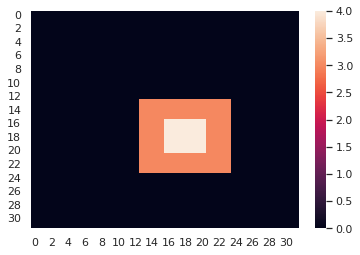

In [43]:

#-------------------- test_bench ----------------------;


#communication pairs : [ [sender 1 | receiver 1]; [sender 2 | receiver 2];...]
communication_pairs = [[5,27],[14,16]]
#communication_pairs = [[4,2],[21,17]]

#traffics for the flows
#traffic_flow = [5000,5000,5000]
traffic_flow = [5000,5000]

#generate heatmap
#output_shape = [32,32]
number_of_output_labels = 5

heat_map = generate_fake_heat_map(number_of_output_labels=number_of_output_labels)
#heat_map =np.zeros((32,32))
#draw the heatmap
ax = sns.heatmap(heat_map,vmin=0, vmax=number_of_output_labels-1) 

cancave_size = [4000,4000]



enable_to_draw_network = 1

#1.5kB = 12 kb
MTU_size = 12 #kb



In [44]:
'''
#generate position information for nodes
number_of_nodes = 30
position = random.rand(number_of_nodes,2)*cancave_size[0]

print(position)
'''

'\n#generate position information for nodes\nnumber_of_nodes = 30\nposition = random.rand(number_of_nodes,2)*cancave_size[0]\n\nprint(position)\n'

In [45]:
# ---manual define postion and heatmap----

In [46]:

number_of_nodes = 40
position = [[ 893.,531.],\
 [1058.,1771.],\
 [ 219.,1352.],\
 [ 249., 229.],\
 [2098.,1263.],\
 [1259., 179.],\
 [1634., 271.],\
 [2716., 736.],\
 [2177.,1370.],\
 [1774., 762.],\
 [ 353.,2154.],\
 [2148.,1718.],\
 [ 971.,1709.],\
 [   7.,2143.],\
 [  34.,2801.],\
 [2247., 902.],\
 [2880., 293.],\
 [2550.,2049.],\
 [1290., 270.],\
 [ 808.,  34.],\
 [2031., 733.],\
 [ 899., 977.],\
 [2760.,2562.],\
 [ 582.,1269.],\
 [ 833., 535.],\
 [ 203.,2839.],\
 [ 694.,1367.],\
 [1533.,1693.],\
 [2022.,2761.],\
 [  58.,2325.],\
 [1756.,2938.],\
 [2081., 484.],\
 [2490.,1973.],\
 [ 509.,1937.],\
 [1787.,1088.],\
 [  37., 699.],\
 [1363.,1859.],\
 [ 787.,2634.],\
 [2005.,2948.],\
 [1621.,1297.]]


In [47]:

heat_map= np.array([\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,4.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,],\
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]\
])
print(heat_map.shape)


(32, 32)


In [48]:
# -----------end --- manual define postion and heatmap

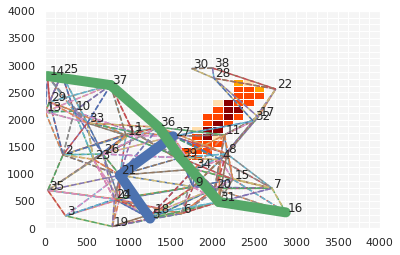

flow start and end nodes:  [[5, 27], [14, 16]]
throughput for each flow:  [4944.038330586836, 4946.758449488199]
delay for each flow:  [22.335490728617586, 359.7690747620745]
data loss caused by buffer overflow:  0.0
sum of traffic  9890.796780075036


In [49]:

[flow_start_end_nodes,final_thorughput,final_delay,data_loss_cause_by_buffer_overflow] = \
time_based_simulator(communication_pairs       = communication_pairs,\
                     traffic_flow              = traffic_flow,\
                     number_of_nodes           = number_of_nodes,\
                     position                  = position,\
                     cancave_size              = cancave_size,\
                     enable_background_traffic = 1,\
                     enable_linear_optimization= 0,\
                     heat_map_ground_truth     = heat_map,\
                     heat_map_estimation       = np.zeros((32,32)),\
                     number_of_heatmap_labels  = number_of_output_labels,\
                     MTU_size                  = 12,\
                     enable_to_draw_network    = 1)

print('flow start and end nodes: ',flow_start_end_nodes)
print('throughput for each flow: ',final_thorughput)
print('delay for each flow: ',final_delay)
print('data loss caused by buffer overflow: ',data_loss_cause_by_buffer_overflow)
print('sum of traffic ',find_sum(final_thorughput))


<ipython-input-35-cdbb79930904>:49: RuntimeWarning: invalid value encountered in double_scalars
  d = abs((x2-x1)*(y1-y0) - (x1-x0)*(y2-y1)) / np.sqrt(np.square(x2-x1) + np.square(y2-y1))


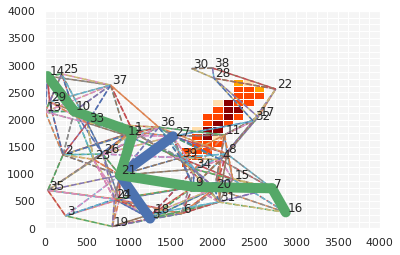

flow start and end nodes:  [[5, 27], [14, 16]]
throughput for each flow:  [4957.276146087298, 4947.93082020981]
delay for each flow:  [18.550600552908605, 54.44305714822336]
data loss caused by buffer overflow:  0.0
sum of traffic  9905.206966297108


In [50]:

[flow_start_end_nodes,final_thorughput,final_delay,data_loss_cause_by_buffer_overflow] = \
time_based_simulator(communication_pairs       = communication_pairs,\
                     traffic_flow              = traffic_flow,\
                     number_of_nodes           = number_of_nodes,\
                     position                  = position,\
                     cancave_size              = cancave_size,\
                     enable_background_traffic = 1,\
                     enable_linear_optimization= 1,\
                     heat_map_ground_truth     = heat_map,\
                     heat_map_estimation       = heat_map,\
                     number_of_heatmap_labels  = number_of_output_labels,\
                     MTU_size                  = 12,\
                     enable_to_draw_network    = 1)

print('flow start and end nodes: ',flow_start_end_nodes)
print('throughput for each flow: ',final_thorughput)
print('delay for each flow: ',final_delay)
print('data loss caused by buffer overflow: ',data_loss_cause_by_buffer_overflow)
print('sum of traffic ',find_sum(final_thorughput))


In [51]:
'''
#plot wireless channel random loss
wireless_channel_random_loss_base = 0.01
sns.distplot(random.normal(loc=wireless_channel_random_loss_base, scale=wireless_channel_random_loss_base/4,size=10000), hist=False)

#print(random.normal(loc=wireless_channel_random_loss_base, scale=wireless_channel_random_loss_base/4,size=10))
'''

'\n#plot wireless channel random loss\nwireless_channel_random_loss_base = 0.01\nsns.distplot(random.normal(loc=wireless_channel_random_loss_base, scale=wireless_channel_random_loss_base/4,size=10000), hist=False)\n\n#print(random.normal(loc=wireless_channel_random_loss_base, scale=wireless_channel_random_loss_base/4,size=10))\n'

In [52]:
'''
# test packets acception rate vs distance; enable to see graphs

#ex. to use function find_packets_acception_rate
#acception_rate = find_packets_acception_rate(distance_between_nodes=1000,signal_frequency,txPower,txAntennaGain,rxAntennaGain,noise)
#print(acception_rate)

noise = -140

#plot acception rate vs distance between nodes
print('Probability of Reception VS Node Distance')
N = 400

x = np.zeros(N)
y = np.zeros(N)

inteval = 20


for a in range(N):
    
    x[a] = inteval*a
    
    y[a] = find_packets_acception_rate(x[a],signal_frequency = 122.75*math.pow(10,6),enable_to_add_random_loss_base = 1,wireless_channel_random_loss_base = 0.01,txPower = 0,txAntennaGain = 0,rxAntennaGain = 0, noise = noise)

plt.xlim(0, 3000)
plt.scatter(x,y,s=3)
plt.show()
'''


"\n# test packets acception rate vs distance; enable to see graphs\n\n#ex. to use function find_packets_acception_rate\n#acception_rate = find_packets_acception_rate(distance_between_nodes=1000,signal_frequency,txPower,txAntennaGain,rxAntennaGain,noise)\n#print(acception_rate)\n\nnoise = -140\n\n#plot acception rate vs distance between nodes\nprint('Probability of Reception VS Node Distance')\nN = 400\n\nx = np.zeros(N)\ny = np.zeros(N)\n\ninteval = 20\n\n\nfor a in range(N):\n    \n    x[a] = inteval*a\n    \n    y[a] = find_packets_acception_rate(x[a],signal_frequency = 122.75*math.pow(10,6),enable_to_add_random_loss_base = 1,wireless_channel_random_loss_base = 0.01,txPower = 0,txAntennaGain = 0,rxAntennaGain = 0, noise = noise)\n\nplt.xlim(0, 3000)\nplt.scatter(x,y,s=3)\nplt.show()\n"